# IMPORT

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
region = 'BARMM'
mother_directory = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/BARMM/"
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/CALABARZON/calabarzon_clusters.csv")
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/BARMM/barmm-clusters.csv")
raw_rg1_clustered = pd.read_csv(mother_directory + "PCF_data.csv")
# use pcf data nalang para you dont get nans for sure?

neighbors_df = pd.read_csv(mother_directory + 'neighbours.csv')
candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")

# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0', 'Cluster.1', 'bg_id','barangay_name', 'city_name', 'province_name', 'region_name'])
neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
raw_rg1_clustered.columns

Index(['Distance_to_Nearest_RHU_km', 'drought_value',
       'flood_probability_value', 'rain intensity_value', 'popden_chi',
       'popden_eld', 'popden_all', 'popden_wom', 'popden_w_1', 'popden_you',
       'HCFAI', 'total_population', 'RHU_Presence', 'ID',
       'buildability_landcov', 'Road_Presence', 'POI_Presence', 'Nearest_RHU',
       'Cluster'],
      dtype='object')

## no need

In [3]:
# # ⭐️ this is the one! this has total_population

# def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
#     total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
#     total_pop = total_ai
#     population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
#     y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
#     mc = np.tanh(y)
#     w_bi = 0.3  # roads
#     w_ci = 0.2  # POIs
#     w_di = 0.5  # land cov
#     b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
#     rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
#     flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
#     drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
#     w_rain = 0.4
#     w_flood = 0.3
#     w_drought = 0.3
#     c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
#     f = b - c
#     f = np.tanh(f)
#     hci = mc * f
#     hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

#     return hcfai

# def overallHCFAI(region_df):
#     if 'HCFAI' in region_df.columns:
#         HCFAI_overall = region_df['HCFAI'].sum()
#     elif 'new HCFAI' in region_df.columns:
#         HCFAI_overall = region_df['new HCFAI'].sum()
#     return HCFAI_overall

# def selectTopSites(candidate_sites, region_df, selected_sites, n):
#     if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
#         while len(selected_sites) < n:
#             new_site = candidate_sites.iloc[:1].copy()
#             selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
#             candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

#     # region_df = region_df.drop('total_population', axis=1)

#     columns_to_merge = ['ID',
#                         'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
#                         'popden_all', 'flood_probability_value', 'rain intensity_value',
#                         'drought_value', 'buildability_landcov', 'RHU_Presence',
#                         'Road_Presence', 'POI_Presence', 'Nearest_RHU',
#                         'Distance_to_Nearest_RHU_km']

#     merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
#     merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
#                                      merged_sites['popden_chi'],
#                                      merged_sites['popden_eld'],
#                                      merged_sites['popden_wom'],
#                                      merged_sites['popden_you'],
#                                      merged_sites['popden_w_1'],
#                                      merged_sites['Distance_to_Nearest_RHU_km'],
#                                      merged_sites['Road_Presence'],
#                                      merged_sites['POI_Presence'],
#                                      merged_sites['buildability_landcov'],
#                                      merged_sites['rain intensity_value'],
#                                      merged_sites['flood_probability_value'],
#                                      merged_sites['drought_value'],
#                                      merged_sites['RHU_Presence'],
#                                      )

#     missing_cols = [col for col in region_df.columns if col != 'ID']
#     for col in missing_cols:
#         if 'ID' not in region_df.columns:
#             region_df.set_index('ID', inplace=True)
#         merged_sites[col] = merged_sites[col].fillna(region_df[col])

#     top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
#     return top_sites

# def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
#     idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
#     adjacent_sites = set()
#     with_RHU_indices = selected_sites['ID'].tolist()
#     for site_id in selected_sites['ID']:
#         if site_id in neighbors_df['ID'].values:
#             neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'neighbours'].iloc[0]
#             adjacent_sites.update(neighbors.split(','))
#     adjacent_sites.update(idx_with_RHU['ID'])
#     adjacent_sites.update(selected_sites['ID'])
#     adjacent_sites = [int(site) for site in adjacent_sites]
#     candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

#     print(f"{len(candidate_sites)} Candidate sites left")
#     print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

#     if len(candidate_sites) > n:
#       for i in with_RHU_indices:
#           print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
#           if i in adjacent_sites:
#               print(f"Site {i} was highkey sus for not saying they have neighbors ...")
#               with_RHU_indices.remove(i)
#               selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
#     elif len(candidate_sites) <= n:
#       return candidate_sites, selected_sites, idx_with_RHU

#     selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
#                                        selected_sites['popden_eld'], selected_sites['popden_wom'],
#                                        selected_sites['popden_you'], selected_sites['popden_w_1'],
#                                        selected_sites['Distance_to_Nearest_RHU_km'],
#                                        selected_sites['Road_Presence'], selected_sites['POI_Presence'],
#                                        selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
#                                        selected_sites['flood_probability_value'], selected_sites['drought_value'],
#                                        selected_sites['RHU_Presence'])
#     return candidate_sites, selected_sites, idx_with_RHU

# def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
#     original_HCFAI = overallHCFAI(region_df)
#     print("Original HCFAI:", original_HCFAI)
#     selected_sites = pd.DataFrame(columns=region_df.columns)
#     top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

#     while len(selected_sites) < num_facilities:
#         candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
#         if len(candidate_sites) <= num_facilities:
#           top_sites = candidate_sites
#         elif len(candidate_sites) > num_facilities:
#           top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
#           selected_sites = top_sites

#         selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
#         remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])]
#         remaining_HCFAI = overallHCFAI(remaining_sites)
#         selected_sites_HCFAI = overallHCFAI(selected_sites)
#         updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
#         print("Updated HCFAI:", updated_HCFAI)
#         print(f"{len(selected_sites)} selected sites")

#         if len(selected_sites) == num_facilities:
#             print("Accept!!!!!!!!!!!!!!")
#             return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

#         elif len(candidate_sites) <= num_facilities:
#             return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

#         else:
#             print("Reject!!!!!!!!!!!!!!")
#             print("Selected sites:", len(selected_sites))
#             top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

#     return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

# need

In [4]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)
    w_bi = 0.3  # roads
    w_ci = 0.2  # POIs
    w_di = 0.5  # land cov
    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
    f = b - c
    f = np.tanh(f)
    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

def overallHCFAI(region_df):
    if 'HCFAI' in region_df.columns:
        HCFAI_overall = region_df['HCFAI'].sum()
    elif 'new HCFAI' in region_df.columns:
        HCFAI_overall = region_df['new HCFAI'].sum()
    return HCFAI_overall

def selectTopSites(candidate_sites, region_df, selected_sites, n):
    if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
        while len(selected_sites) < n:
            new_site = candidate_sites.iloc[:1].copy()
            selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
            candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

    # region_df = region_df.drop('total_population', axis=1)

    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km']

    merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
    merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
                                     merged_sites['popden_chi'],
                                     merged_sites['popden_eld'],
                                     merged_sites['popden_wom'],
                                     merged_sites['popden_you'],
                                     merged_sites['popden_w_1'],
                                     merged_sites['Distance_to_Nearest_RHU_km'],
                                     merged_sites['Road_Presence'],
                                     merged_sites['POI_Presence'],
                                     merged_sites['buildability_landcov'],
                                     merged_sites['rain intensity_value'],
                                     merged_sites['flood_probability_value'],
                                     merged_sites['drought_value'],
                                     merged_sites['RHU_Presence'],
                                     )

    missing_cols = [col for col in region_df.columns if col != 'ID']
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])

    top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
    return top_sites

def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
    idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
    adjacent_sites = set()
    with_RHU_indices = selected_sites['ID'].tolist()
    for site_id in selected_sites['ID']:
        if site_id in neighbors_df['ID'].values:
            neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'neighbours'].iloc[0]
            adjacent_sites.update(neighbors.split(','))
    adjacent_sites.update(idx_with_RHU['ID'])
    adjacent_sites.update(selected_sites['ID'])
    adjacent_sites = [int(site) for site in adjacent_sites]
    candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

    # print(f"{len(candidate_sites)} Candidate sites left")
    # print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

    if len(candidate_sites) > n:
      for i in with_RHU_indices:
          # print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
          if i in adjacent_sites:
              # print(f"Site {i} was highkey sus for not saying they have neighbors ...")
              with_RHU_indices.remove(i)
              selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
    elif len(candidate_sites) <= n:
      return candidate_sites, selected_sites, idx_with_RHU

    selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
                                       selected_sites['popden_eld'], selected_sites['popden_wom'],
                                       selected_sites['popden_you'], selected_sites['popden_w_1'],
                                       selected_sites['Distance_to_Nearest_RHU_km'],
                                       selected_sites['Road_Presence'], selected_sites['POI_Presence'],
                                       selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
                                       selected_sites['flood_probability_value'], selected_sites['drought_value'],
                                       selected_sites['RHU_Presence'])
    return candidate_sites, selected_sites, idx_with_RHU

def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
    original_HCFAI = overallHCFAI(region_df)
    # print("Original HCFAI:", original_HCFAI)
    # print(region_df.columns)
    region_df = region_df.drop(['total_population'], axis=1)

    selected_sites = pd.DataFrame(columns=region_df.columns)
    top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    while len(selected_sites) < num_facilities:
        # candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        if len(candidate_sites) <= num_facilities:
          top_sites = candidate_sites
        elif len(candidate_sites) > num_facilities:
          top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
          selected_sites = top_sites

        candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
        remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])] # HCFAI did not change

        selected_sites['RHU_Presence'] = 1
        remaining_HCFAI = overallHCFAI(remaining_sites)
        selected_sites_HCFAI = overallHCFAI(selected_sites)
        updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI

         # Assuming df is your DataFrame
        vp =  selected_sites['popden_chi'] + selected_sites['popden_eld'] + selected_sites['popden_wom'] + selected_sites['popden_you'] + selected_sites['popden_w_1'] + selected_sites['popden_you']
        gen = selected_sites['popden_all'] - vp
        all = vp + gen
        selected_sites['total_population'] = all
        # print(selected_sites['total_population']) # trying to see how much more of the population gets healthcare access

        # places_with_rhu = region_df.copy()
        # x = region_df[region_df['RHU_Presence' == 1]]
        # print(x['total_population'])

        # print("Updated HCFAI:", updated_HCFAI)
        # print(f"{len(selected_sites)} selected sites")

        if len(selected_sites) == num_facilities:
            print("Accept!!!!!!!!!!!!!!")
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        elif len(candidate_sites) <= num_facilities:
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        else:
            print("Reject!!!!!!!!!!!!!!")
            print("Selected sites:", len(selected_sites))
            top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

# LGA - PCF from formula

In [ ]:
print(f"Candidate sites: {len(candidate_sites)}")
PCF = 61
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)

selected_facilities = list(selected_facilities['ID'])
hex_with_RHU = list(hex_with_RHU['ID'])
hex_with_RHU
print(f"Optimal sites: {len(list(set(selected_facilities)))}")
print(f"Sites with RHUs: {len(hex_with_RHU)}")

os = selected_facilities
cs = list(candidate_sites['ID'])
es = hex_with_RHU

# hex_with_RHU = list(hex_with_RHU['ID'])
print(f"{len(cs)} Candidate Sites")
print(f"{cs}")
print(f"{len(list(set(os)))} Optimal Sites")
print(f"{list(set(os))}")
print(f"{len(es)} existing rhu sites")
print(f"{es}")
print(f"UPDATED HCFAI: {updated_HCFAI}")

Candidate sites: 417
332 Candidate sites left
BEFORE MODIFYING HCFAI
Region-wise HCFAI Comparison (Original vs Updated):
          ID     HCFAI  updated_HCFAI  HCFAI_diff
0    2708537  0.512028       0.426808   -0.085220
1    2720914  0.419687       0.391650   -0.028037
2    2722294  0.431214       0.398511   -0.032703
3    2722295  0.430603       0.391650   -0.038953
4    2723676  0.485164       0.404277   -0.080887
..       ...       ...            ...         ...
582  3410546  0.015421       0.359011    0.343591
583  3410547  0.158447       0.399646    0.241200
584  3411931  0.041748       0.365107    0.323359
585  3413311  0.039166       0.364551    0.325385
586  3413312  0.230801       0.420491    0.189690

[587 rows x 4 columns]
ORIGINAL VALUE: 185.07800036202622
UPDATED VALUE: 252.55226956785222
Optimal sites: 61
Sites with RHUs: 25
417 Candidate Sites
[2720914, 2722294, 2722295, 2723676, 2723677, 2723678, 2725057, 2725059, 2725060, 2726440, 2726442, 2727820, 2727821, 2727822, 2

# LGA - expected PCF in PHFDP

In [5]:
# print(f"Candidate sites: {len(candidate_sites)}")
# print(f"Existing RHU sites: {existing_region_rhus[existing_region_rhus['RHU_Presence'] == 1]['ID'].tolist()}")
# print(list(candidate_sites['ID']))
# print(list(existing_region_rhus[existing_region_rhus['RHU_Presence'] == 1]['ID']))

# selected_facilities, updated_HCFAI, og_HCFAI = optimize(raw_rg1_clustered, PCF) # 81 for dropping non buildable; 363 for validation
PCF = 391
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)

# print(f"Optimal sites: {len(selected_facilities)}")
# print(selected_facilities)

os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
es = list(hex_with_RHU['ID'])

# hex_with_RHU = list(hex_with_RHU['ID'])
print(f"{cs}")
print(f"{len(set(os))} optimal sites")
print(f"{list(set(os))}")
print(f"{es}")
print(f"UPDATED HCFAI: {updated_HCFAI}")

[2720914, 2722294, 2722295, 2723676, 2723677, 2723678, 2725057, 2725059, 2725060, 2726440, 2726442, 2727820, 2727821, 2727822, 2727823, 2727824, 2727825, 2729204, 2729205, 2729207, 2730584, 2730585, 2730589, 2797076, 2823336, 2823339, 2824707, 2824713, 2824714, 2824717, 2824718, 2824719, 2826090, 2826096, 2830234, 2830235, 2830236, 2830249, 2831616, 2831617, 2831618, 2831620, 2831622, 2831626, 2831631, 2832998, 2833000, 2833001, 2833006, 2833008, 2833010, 2833012, 2834383, 2834385, 2834389, 2834390, 2834391, 2834392, 2835767, 2835768, 2835769, 2835770, 2835771, 2835772, 2860626, 2862007, 2862008, 2862010, 2862011, 2863387, 2863388, 2863389, 2863391, 2863392, 2863393, 2864769, 2864771, 2864772, 2864774, 2864775, 2866163, 2866165, 2867534, 2867535, 2867536, 2867537, 2867538, 2867545, 2867546, 2867547, 2867548, 2867549, 2867553, 2868915, 2868917, 2868918, 2868926, 2868928, 2868929, 2868933, 2868934, 2868935, 2870296, 2870297, 2870298, 2870299, 2870310, 2870316, 2871676, 2871678, 2871679, 

In [6]:
# Filter rows where 'rhupresence' equals 1 and sum the 'total_population' column
s = raw_rg1_clustered[raw_rg1_clustered['RHU_Presence'] == 1]['total_population'].sum()
print("Total population where rhupresence = 1:", s)

# print("Duplicate IDs in selected_facilities:")
# print(selected_facilities[selected_facilities['ID'].duplicated(keep=False)])

# print("Duplicate IDs in raw_rg1_clustered:")
# print(raw_rg1_clustered[raw_rg1_clustered['ID'].duplicated(keep=False)])

# raw_rg1_clustered = raw_rg1_clustered.drop_duplicates(subset='ID', keep='first')
selected_facilities = selected_facilities.drop_duplicates(subset='ID', keep='first')

raw_rg1_clustered.set_index('ID', inplace=True)
selected_facilities.set_index('ID', inplace=True)
raw_rg1_clustered.update(selected_facilities)
raw_rg1_clustered.reset_index(inplace=True)

x = raw_rg1_clustered[raw_rg1_clustered['RHU_Presence'] == 1]['total_population'].sum()
print("Total population WHEN THE UPDATED SITES are RHU_Presence = 1:", x)

pop_increase = ((x - s)/s)*100
print(f"Population % increase with facility access: {pop_increase}%")

a = 97530
p = x*a
p_init = s*a
print(f"Population (individuals) before additional RHUs: {p_init}")
print(f"Population (individuals) after additional RHUs: {p}")

Total population where rhupresence = 1: 0.8688270983443943
Total population WHEN THE UPDATED SITES are RHU_Presence = 1: 1.4201631321646833
Population % increase with facility access: 63.457508964775045%
Population (individuals) before additional RHUs: 84736.70690152877
Population (individuals) after additional RHUs: 138508.51028002155


# Validation - PCF from formula

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID', 'total_population',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

166.0625173354173
19.015483026608926
166.58530191198145
18.49269845004477
166.50906000286403
18.56894035916219
162.77015703323394
22.307843328792252
165.48341037768716
19.594589984339045
165.0200882517602
20.057912110266034
166.17684131804145
18.901159043984784
166.7839592990137
18.294041063012518
164.66145138888163
20.41654897314459
168.60521531279733
16.472785049228914
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 185.07800036202622
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  185.07800036202624
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  193.36195729116366


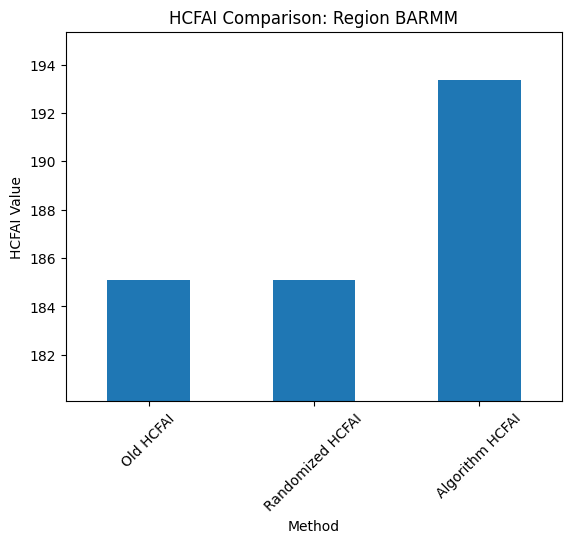

In [ ]:
hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region BARMM')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()

# Validation - PCF from PHFDP

In [ ]:
# import random
# import pandas as pd

# def getRandom48(candidate_sites, random_seed=None):
#     """
#     Randomly select 48 sites from the candidate sites DataFrame.

#     Parameters:
#         candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
#         random_seed (int): Random seed for reproducibility.

#     Returns:
#         DataFrame: Randomly selected 48 sites DataFrame.
#     """
#     if random_seed is not None:
#         random.seed(random_seed)
#     candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
#     random_48 = candidate_sites_shuffled.sample(n=PCF)
#     return random_48


# def randomize(region_df, candidate_sites, random_seed):
#     """
#     Randomize the selection of 48 sites and update the overall HCFAI value.
#     Parameters:
#         region_df (DataFrame): DataFrame containing information about all sites in the region.
#     Returns:
#         tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
#     """
#     HCFAI_overall_before = overallHCFAI(region_df)
#     # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
#     random_48 = getRandom48(candidate_sites, random_seed)
#     columns_to_merge = ['ID',
#                         'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
#                         'popden_all', 'flood_probability_value', 'rain intensity_value',
#                         'drought_value', 'buildability_landcov', 'RHU_Presence',
#                         'Road_Presence', 'POI_Presence', 'Nearest_RHU',
#                         'Distance_to_Nearest_RHU_km', 'HCFAI']
#     merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
#     missing_cols = [col for col in region_df.columns if col != ['ID']]
#     for col in missing_cols:
#         if 'ID' not in region_df.columns:
#             region_df.set_index('ID', inplace=True)
#         merged_sites[col] = merged_sites[col].fillna(region_df[col])
#     # Calculate HCFAI for the remaining sites in region_df
#     remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
#     remaining_HCFAI = overallHCFAI(remaining_sites)
#     print(remaining_HCFAI)
#     selected_sites_HCFAI = overallHCFAI(merged_sites)
#     print(selected_sites_HCFAI)

#     # Calculate updated overall HCFAI
#     updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
#     # print(f"Updated HCFAI: ", updated_HCFAI)
#     return updated_HCFAI, random_48['ID'].tolist()

# # Example usage
# rdm_hcfai = []
# rdm_points = []
# for i in range(10):
#     random_seed = i  # Use a different random seed for each iteration
#     rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
#     rdm_hcfai.append(rdm_ovHCFAI)
#     rdm_points.append(rdm_48)

# rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
# highest_rdm_HCFAI = max(rdm_hcfai)
# # print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

# Results_rdmsum = pd.DataFrame({
#     'Hex IDs': rdm_points,
#     'HCFAI': rdm_hcfai
# })

# print("=========== OG HCFAI RESULTS ===========")
# print("ORIGINAL HCFAI", og_HCFAI)
# print("=========== RANDOM HCFAI RESULTS ===========")
# # print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
# print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# # print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
# print("=========== OPTIMIZED HCFAI RESULTS ===========")
# print("OPTIMIZED HCFAI ", updated_HCFAI)

# hcfai_compare_df =  pd.DataFrame(
#     {' ': ['SUM'],
#     'Old HCFAI': og_HCFAI,
#      'Randomized HCFAI': highest_rdm_HCFAI,
#      'Algorithm HCFAI': updated_HCFAI
#     })

# import matplotlib.pyplot as plt
# # Preparing the data for plotting
# # Since we have only one row with label 'SUM', we'll use it as index
# hcfai_compare_df.set_index(' ', inplace=True)
# hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# # Plotting the bar chart
# hcfai_compare_df.plot(kind='bar', legend=False)
# plt.title(f'HCFAI Comparison: Region BARMM')
# plt.ylabel('HCFAI Value')
# plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
# plt.xlabel('Method')
# plt.xticks(rotation=45)
# plt.show()

Index(['Distance_to_Nearest_RHU_km', 'drought_value',
       'flood_probability_value', 'rain intensity_value', 'popden_chi',
       'popden_eld', 'popden_all', 'popden_wom', 'popden_w_1', 'popden_you',
       'HCFAI', 'total_population', 'RHU_Presence', 'ID',
       'buildability_landcov', 'Road_Presence', 'POI_Presence', 'Nearest_RHU',
       'Cluster'],
      dtype='object')
59.50771220809014
125.57028815393609
60.32705193395159
124.75094842807465
58.573602619192926
126.5043977428333
63.26252727888306
121.81547308314316
59.64548235787585
125.43251800415038
60.022024216540686
125.05597614548554
59.05692809228658
126.02107226973965
60.39214557233926
124.68585478968697
60.1029989002667
124.97500146175953
61.42299937643267
123.65500098559356
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 185.07800036202622
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  185.07800036202624
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  198.706197958448

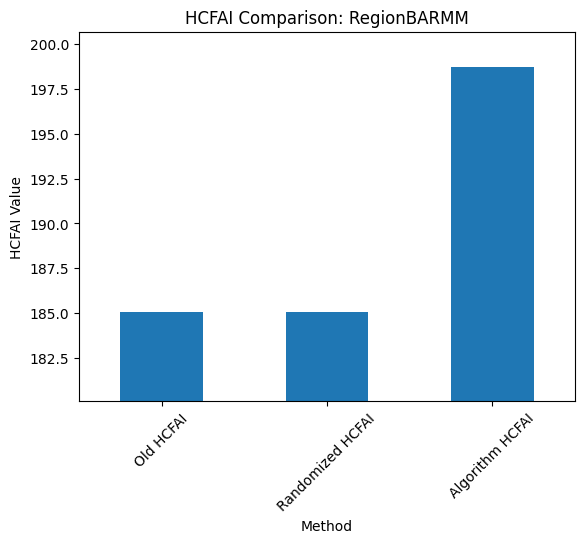

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID', 'total_population',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

print(raw_rg1_clustered.columns)
# raw_rg1_clustered = raw_rg1_clustered.drop('total_population',axis=1, inplace=True)

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region{region}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()